In [294]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import glob
import pickle

import numpy as np
import numpy.lib.recfunctions as rfn

import matplotlib.pyplot as plt
import scipy.integrate, scipy.interpolate, scipy.stats

from astropy.table import Table

from sklearn.linear_model import LinearRegression

from ltsfit import lts_linefit

from colossus.halo import mass_defs
from colossus.halo import concentration
from colossus.cosmology import cosmology

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- Some of the calculation here also depends on the `awesome_cluster_finder` package by Christopher Bradshaw
    - It will be available [in this Github repo](https://github.com/Christopher-Bradshaw/awesome_cluster_finder)

- If you don't have access to `acf` or don't have space for downloading the data, you can load the saved data in this folder to reproduce the figure.


In [3]:
import awesome_cluster_finder as acf

Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
updating config! Using simulation:cb_sham_mdpl:/home/christopher/research/cluster_finder/_data/cb_sham_mdpl/latest.npz

Fiducial cosmo
 Cosmology "planck15" 
    flat = True, Om0 = 0.3000, Ode0 = 0.6999, Ob0 = 0.0486, H0 = 70.00, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False

Sim cosmo
 Cosmology "sim_cosmo" 
    flat = True, Om0 = 0.3071, Ode0 = 0.6928, Ob0 = 0.0482, H0 = 70.00, sigma8 = 0.8228, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [4]:
import jianbing

from jianbing import scatter

In [5]:
fig_dir = jianbing.FIG_DIR

data_dir = jianbing.DATA_DIR
sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

### Estimate the $\sigma_{\mathcal{O}}$

#### M*100

In [6]:
# Assuming alpha=0.2
# Bin 1
print(np.round(scatter.sigo_to_sigm(0.15, alpha=0.34), 2))

# Bin 2
print(np.round(scatter.sigo_to_sigm(0.20, alpha=0.20), 2))

# Bin 3
print(np.round(scatter.sigo_to_sigm(0.30, alpha=0.20), 2))

0.35
0.5
0.54


In [188]:
# Bin 1
print(np.round(scatter.sigo_to_sigm(0.22, alpha=0.36), 2))

0.42


In [365]:
print(np.round(scatter.sigo_to_sigm(0.4, alpha=0.72), 2))

0.4


#### Richness

In [9]:
print(np.round(scatter.sigo_to_sigm(0.26, alpha=0.86), 2))

0.27


In [183]:
print(np.round(scatter.sigo_to_sigm(0.38, alpha=0.86), 2))

0.35


### UniverseMachine: logMvir v.s. in-situ & ex-situ stellar mass

In [192]:
um_cat = np.load(
    '/Users/song/Dropbox/work/project/asap/data/umachine/um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5.npy')

um_cen = um_cat[um_cat['upid'] == -1]

logm_ins = um_cen['logms_gal']
logm_exs = um_cen['logms_icl']
logmh_vir = um_cen['logmh_vir']

#### Ex-situ

[0.85459552] -0.3708891341052887


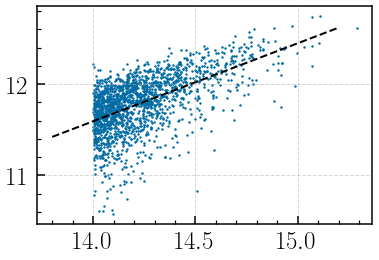

In [197]:
mask = um_cen['logmh_vir'] >= 14.0

x_err = np.full(len(um_cen[mask]), 0.03)
y_err = np.full(len(um_cen[mask]), 0.04)

w = 1. / (y_err ** 2.)

x_arr, y_arr = um_cen[mask]['logmh_vir'], um_cen[mask]['logms_icl']

reg = LinearRegression().fit(
    x_arr.reshape(-1, 1), y_arr, sample_weight=w)

print(reg.coef_, reg.intercept_)

plt.scatter(x_arr, y_arr, s=2)

x_grid = np.linspace(13.8, 15.2, 100)
plt.plot(x_grid, reg.coef_ * x_grid + reg.intercept_, linewidth=2.0, linestyle='--', c='k')

sig_int:     0.0000     21.3181
Computing sig_int
sig_int:     0.0000     21.3181
sig_int:     0.3103     -0.3863
sig_int:     0.3048     -0.3643
sig_int:     0.2145      0.2530
sig_int:     0.2515     -0.0767
sig_int:     0.2429     -0.0126
sig_int:     0.2413      0.0001
sig_int:     0.2414     -0.0008
Computing sig_int error
sig_int:     0.2413      0.0338
sig_int:     0.3103     -0.3526
sig_int:     0.2473     -0.0127
sig_int:     0.2456     -0.0003
sig_int:     0.2455      0.0006
Repeat at best fitting solution
sig_int:     0.2413      0.0001
################# Values and formal errors ################
 intercept:  11.7441 +/- 0.0061
     slope:  0.867 +/- 0.028
   scatter:  0.2413 +/- 0.0044
Observed rms scatter: 0.25
y = a + b*(x - pivot) with pivot = 14.17
Spearman r=0.56 and p=5e-144
Pearson r=0.57 and p=2e-156
##########################################################
seconds 8.86


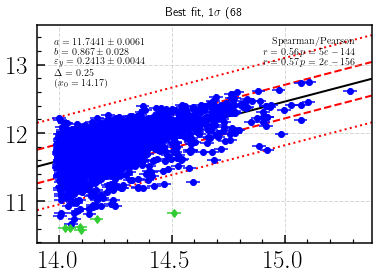

In [194]:
lts_linefit.lts_linefit(x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

In [195]:
scatter.sigo_to_sigm(0.25, alpha=0.867)

0.25831926012461853

#### In-situ

[0.10615325] 9.506636236755043


(8.9, 12.2)

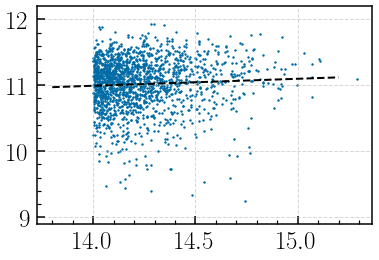

In [198]:
mask = um_cen['logmh_vir'] >= 14.0

x_err = np.full(len(um_cen[mask]), 0.03)
y_err = np.full(len(um_cen[mask]), 0.04)

w = 1. / (y_err ** 2.)

x_arr, y_arr = um_cen[mask]['logmh_vir'], um_cen[mask]['logms_gal']

reg = LinearRegression().fit(
    x_arr.reshape(-1, 1), y_arr, sample_weight=w)

print(reg.coef_, reg.intercept_)

plt.scatter(x_arr, y_arr, s=2)

x_grid = np.linspace(13.8, 15.2, 100)
plt.plot(x_grid, reg.coef_ * x_grid + reg.intercept_, linewidth=2.0, linestyle='--', c='k')
plt.ylim(8.9, 12.2)

sig_int:     0.0000     44.3006
Computing sig_int
sig_int:     0.0000     44.3006
sig_int: 41162071657.5467     -1.0000
sig_int: 40253428806.5956     -1.0000
sig_int: 20126714403.2978     -1.0000
sig_int: 10063357201.6489     -1.0000
sig_int: 5031678600.8245     -1.0000
sig_int: 2515839300.4122     -1.0000
sig_int: 1257919650.2061     -1.0000
sig_int: 628959825.1031     -1.0000
sig_int: 314479912.5515     -1.0000
sig_int: 157239956.2758     -1.0000
sig_int: 78619978.1379     -1.0000
sig_int: 39309989.0689     -1.0000
sig_int: 19654994.5345     -1.0000
sig_int: 9827497.2672     -1.0000
sig_int: 4913748.6336     -1.0000
sig_int: 2456874.3168     -1.0000
sig_int: 1228437.1584     -1.0000
sig_int: 614218.5792     -1.0000
sig_int: 307109.2896     -1.0000
sig_int: 153554.6448     -1.0000
sig_int: 76777.3224     -1.0000
sig_int: 38388.6612     -1.0000
sig_int: 19194.3306     -1.0000
sig_int:  9597.1653     -1.0000
sig_int:  4798.5827     -1.0000
sig_int:  2399.2913     -1.0000
sig_int:  1199.

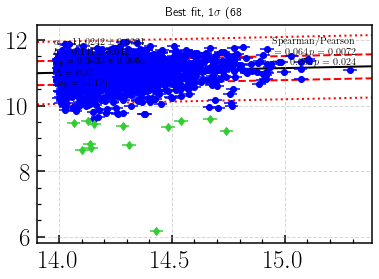

In [294]:
lts_linefit.lts_linefit(x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

In [199]:
scatter.sigo_to_sigm(0.37, alpha=0.141)

0.5675753929174001

### Ex-situ mass in Illustris and IllustrisTNG


In [319]:
def exsitu_frac_sum(gal):
    """Summarize the ex-situ fraction of a galaxy."""
    summary = {}
    
    # Central flag
    summary['cen'] = gal['info']['cen_flag']
    # Total stellar mass
    summary['logms'] = gal['info']['logms']
    # Total halo mass
    summary['logm_200c'] = gal['info']['logm200c']
    
    c_200c = concentration.concentration(
        10.0 **  summary['logm_200c'], '200c', 0.4, model='diemer19')
    mvir, rvir, cvir = mass_defs.changeMassDefinition(
        10.0 **  summary['logm_200c'], c_200c, 0.4, '200c', 'vir')
    summary['logm_vir'] = np.log10(mvir)
    
    summary['logm_ins'] = gal['info']['logms_map_ins']
    summary['logm_exs'] = gal['info']['logms_map_exs']
    
    # Total ex-situ fraction
    summary['fexs_tot'] = (10.0 ** gal['info']['logms_map_exs'] / 10.0 ** gal['info']['logms_map_gal'])
    
    # 5kpc, 10kpc, 100kpc stellar mass
    summary['logms_5'] = np.log10(gal['aper']['maper_gal'][6])
    summary['logms_10'] = np.log10(gal['aper']['maper_gal'][9])
    summary['logms_30'] = np.log10(gal['aper']['maper_gal'][12])
    summary['logms_40'] = np.log10(gal['aper']['maper_gal'][13])
    summary['logms_60'] = np.log10(gal['aper']['maper_gal'][14])
    summary['logms_100'] = np.log10(gal['aper']['maper_gal'][16])
    summary['logms_150'] = np.log10(gal['aper']['maper_gal'][17])
    
    summary['logms_30_100'] = np.log10(gal['aper']['maper_gal'][16] - gal['aper']['maper_gal'][12])
    summary['logms_40_100'] = np.log10(gal['aper']['maper_gal'][16] - gal['aper']['maper_gal'][13])
    summary['logms_60_100'] = np.log10(gal['aper']['maper_gal'][16] - gal['aper']['maper_gal'][14])
    summary['logms_30_150'] = np.log10(gal['aper']['maper_gal'][17] - gal['aper']['maper_gal'][12])
    summary['logms_40_150'] = np.log10(gal['aper']['maper_gal'][17] - gal['aper']['maper_gal'][13])
    summary['logms_60_150'] = np.log10(gal['aper']['maper_gal'][17] - gal['aper']['maper_gal'][14])
    
    # Mass fraction in 5 and 10 kpc
    summary['fmass_5'] = gal['aper']['maper_gal'][6] / gal['aper']['maper_gal'][16]
    summary['fmass_10'] = gal['aper']['maper_gal'][9] / gal['aper']['maper_gal'][16]
    
    # Ex-situ fraction within 5, 10, 100 kpc 
    summary['fexs_5'] = gal['aper']['maper_exs'][6] / gal['aper']['maper_gal'][6]
    summary['fexs_10'] = gal['aper']['maper_exs'][9] / gal['aper']['maper_gal'][9]
    summary['fexs_100'] = gal['aper']['maper_exs'][9] / gal['aper']['maper_gal'][9]
    
    # In-situ and ex-situ mass profile
    summary['rad'] = gal['aper']['rad_mid']
    summary['mprof_ins'] = gal['aper']['mprof_ins']
    summary['mprof_exs'] = gal['aper']['mprof_exs']
    
    return summary

#### Illustris @ z=0.4

In [317]:
data_dir = '/Volumes/astro6/massive/simulation/riker/ori/sum'

xy_list = glob.glob(os.path.join(data_dir, '*xy_sum.npy'))
xy_sum = [np.load(gal, allow_pickle=True) for gal in xy_list]

print("# There are %d Illustris massive galaxies" % len(xy_list))

ori_cat = Table([exsitu_frac_sum(gal) for gal in xy_sum])

# There are 449 TNG massive galaxies


sig_int:     0.0000     72.8034
Computing sig_int
sig_int:     0.0000     72.8034
sig_int:     0.3483     -0.6541
sig_int:     0.3452     -0.6478
sig_int:     0.1726      0.3963
sig_int:     0.2381     -0.2622
sig_int:     0.2120     -0.0710
sig_int:     0.2038      0.0047
sig_int:     0.2043     -0.0003
sig_int:     0.2042      0.0007
Computing sig_int error
sig_int:     0.2043      0.2018
sig_int:     0.3483     -0.4520
sig_int:     0.2487     -0.1216
sig_int:     0.2320     -0.0214
sig_int:     0.2288      0.0005
sig_int:     0.2289     -0.0003
Repeat at best fitting solution
sig_int:     0.2043     -0.0003
################# Values and formal errors ################
 intercept:  11.528 +/- 0.030
     slope:  0.80 +/- 0.12
   scatter:  0.204 +/- 0.025
Observed rms scatter: 0.21
y = a + b*(x - pivot) with pivot = 13.44
Spearman r=0.6 and p=2.7e-06
Pearson r=0.7 and p=1.2e-08
##########################################################
seconds 17.99


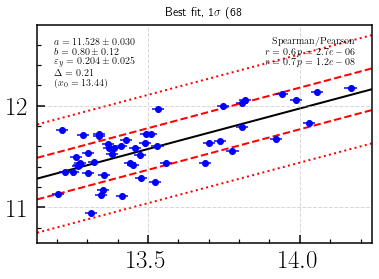

In [309]:
mask = ori_cat['cen'] & (ori_cat['logm_vir'] >= 13.2)

x_arr = ori_cat['logm_vir'][mask]
y_arr = ori_cat['logm_exs'][mask]

x_err = np.full(len(x_arr), 0.02)
y_err = np.full(len(y_arr), 0.01)

lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

sig_int:     0.0000     91.3164
Computing sig_int
sig_int:     0.0000     91.3164
sig_int:     0.2462     -0.6629
sig_int:     0.2444     -0.6580
sig_int:     0.1222      0.3577
sig_int:     0.1652     -0.2540
sig_int:     0.1474     -0.0634
sig_int:     0.1423      0.0037
sig_int:     0.1426     -0.0002
sig_int:     0.1425      0.0008
Computing sig_int error
sig_int:     0.1426      0.2018
sig_int:     0.2462     -0.4609
sig_int:     0.1742     -0.1260
sig_int:     0.1620     -0.0222
sig_int:     0.1597      0.0005
sig_int:     0.1598     -0.0003
Repeat at best fitting solution
sig_int:     0.1426     -0.0002
################# Values and formal errors ################
 intercept:  11.384 +/- 0.021
     slope:  0.360 +/- 0.081
   scatter:  0.143 +/- 0.017
Observed rms scatter: 0.14
y = a + b*(x - pivot) with pivot = 13.44
Spearman r=0.47 and p=0.00052
Pearson r=0.53 and p=5.6e-05
##########################################################
seconds 16.91


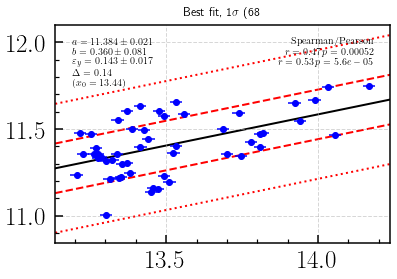

In [308]:
mask = ori_cat['cen'] & (ori_cat['logm_vir'] >= 13.2)

x_arr = ori_cat['logm_vir'][mask]
y_arr = ori_cat['logm_ins'][mask]

x_err = np.full(len(x_arr), 0.02)
y_err = np.full(len(y_arr), 0.01)

lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

sig_int:     0.0000     50.1199
Computing sig_int
sig_int:     0.0000     50.1199
sig_int:     0.3119     -0.5325
sig_int:     0.3086     -0.5226
sig_int:     0.1543      0.8662
sig_int:     0.2505     -0.2786
sig_int:     0.2004      0.1204
sig_int:     0.2155     -0.0291
sig_int:     0.2126     -0.0024
sig_int:     0.2123      0.0000
sig_int:     0.2124     -0.0010
Computing sig_int error
sig_int:     0.2123      0.2020
sig_int:     0.3119     -0.3305
sig_int:     0.2501     -0.0740
sig_int:     0.2399     -0.0124
sig_int:     0.2380      0.0002
sig_int:     0.2381     -0.0006
Repeat at best fitting solution
sig_int:     0.2123      0.0000
################# Values and formal errors ################
 intercept:  10.994 +/- 0.031
     slope:  0.92 +/- 0.12
   scatter:  0.212 +/- 0.026
Observed rms scatter: 0.21
y = a + b*(x - pivot) with pivot = 13.44
Spearman r=0.66 and p=1.2e-07
Pearson r=0.73 and p=8.7e-10
##########################################################
seconds 18.53


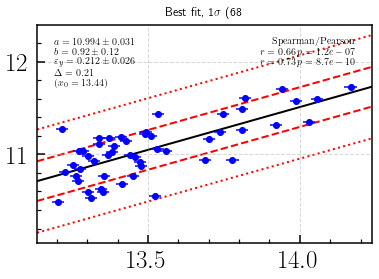

In [322]:
mask = ori_cat['cen'] & (ori_cat['logm_vir'] >= 13.2)

x_arr = ori_cat['logm_vir'][mask]
y_arr = ori_cat['logms_40_100'][mask]

x_err = np.full(len(x_arr), 0.02)
y_err = np.full(len(y_arr), 0.02)

lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

sig_int:     0.0000     34.4278
Computing sig_int
sig_int:     0.0000     34.4278
sig_int:     0.1939     -0.4617
sig_int:     0.1913     -0.4474
sig_int:     0.1122      0.5631
sig_int:     0.1563     -0.1779
sig_int:     0.1387      0.0375
sig_int:     0.1418     -0.0056
sig_int:     0.1414     -0.0002
sig_int:     0.1413      0.0008
Computing sig_int error
sig_int:     0.1414      0.2019
sig_int:     0.1939     -0.2597
sig_int:     0.1643     -0.0529
sig_int:     0.1596     -0.0087
sig_int:     0.1587      0.0001
sig_int:     0.1587     -0.0007
Repeat at best fitting solution
sig_int:     0.1414     -0.0002
################# Values and formal errors ################
 intercept:  11.740 +/- 0.021
     slope:  0.594 +/- 0.081
   scatter:  0.141 +/- 0.017
Observed rms scatter: 0.14
y = a + b*(x - pivot) with pivot = 13.44
Spearman r=0.63 and p=8e-07
Pearson r=0.72 and p=2.5e-09
##########################################################
seconds 17.35


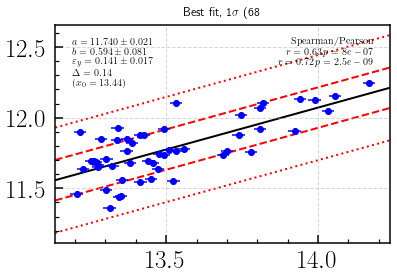

In [323]:
mask = ori_cat['cen'] & (ori_cat['logm_vir'] >= 13.2)

x_arr = ori_cat['logm_vir'][mask]
y_arr = ori_cat['logms_100'][mask]

x_err = np.full(len(x_arr), 0.02)
y_err = np.full(len(y_arr), 0.02)

lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

sig_int:     0.0000     31.2502
Computing sig_int
sig_int:     0.0000     31.2502
sig_int:     0.1637     -0.4382
sig_int:     0.1615     -0.4226
sig_int:     0.1009      0.4391
sig_int:     0.1318     -0.1405
sig_int:     0.1206      0.0215
sig_int:     0.1221     -0.0025
sig_int:     0.1219     -0.0000
sig_int:     0.1218      0.0009
Computing sig_int error
sig_int:     0.1219      0.2020
sig_int:     0.1637     -0.2361
sig_int:     0.1412     -0.0468
sig_int:     0.1376     -0.0076
sig_int:     0.1369      0.0001
sig_int:     0.1370     -0.0007
Repeat at best fitting solution
sig_int:     0.1219     -0.0000
################# Values and formal errors ################
 intercept:  11.444 +/- 0.018
     slope:  0.389 +/- 0.070
   scatter:  0.122 +/- 0.015
Observed rms scatter: 0.12
y = a + b*(x - pivot) with pivot = 13.44
Spearman r=0.53 and p=6.1e-05
Pearson r=0.62 and p=1.3e-06
##########################################################
seconds 17.43


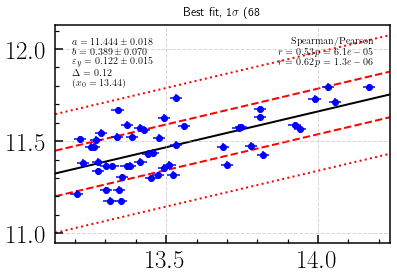

In [324]:
mask = ori_cat['cen'] & (ori_cat['logm_vir'] >= 13.2)

x_arr = ori_cat['logm_vir'][mask]
y_arr = ori_cat['logms_10'][mask]

x_err = np.full(len(x_arr), 0.02)
y_err = np.full(len(y_arr), 0.02)

lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

#### TNG100 @ z=0.4

In [342]:
data_dir = '/Volumes/astro6/massive/simulation/riker/tng/sum'

xy_list = glob.glob(os.path.join(data_dir, '*xy_sum.npy'))
xy_sum = [np.load(gal, allow_pickle=True) for gal in xy_list]

print("# There are %d TNG massive galaxies" % len(xy_list))

tng_cat = Table([exsitu_frac_sum(gal) for gal in xy_sum])

# There are 296 TNG massive galaxies


sig_int:     0.0000     73.7327
Computing sig_int
sig_int:     0.0000     73.7327
sig_int:     0.2909     -0.5637
sig_int:     0.2887     -0.5570
sig_int:     0.1443      0.7501
sig_int:     0.2272     -0.2865
sig_int:     0.1800      0.1316
sig_int:     0.1949     -0.0327
sig_int:     0.1919     -0.0030
sig_int:     0.1916      0.0000
sig_int:     0.1917     -0.0010
Computing sig_int error
sig_int:     0.1916      0.1571
sig_int:     0.2909     -0.4066
sig_int:     0.2193     -0.0776
sig_int:     0.2102     -0.0101
sig_int:     0.2089      0.0001
sig_int:     0.2090     -0.0007
Repeat at best fitting solution
sig_int:     0.1916      0.0000
################# Values and formal errors ################
 intercept:  11.437 +/- 0.021
     slope:  0.784 +/- 0.077
   scatter:  0.192 +/- 0.017
Observed rms scatter: 0.19
y = a + b*(x - pivot) with pivot = 13.48
Spearman r=0.7 and p=3.1e-13
Pearson r=0.75 and p=4.5e-16
##########################################################
seconds 18.73


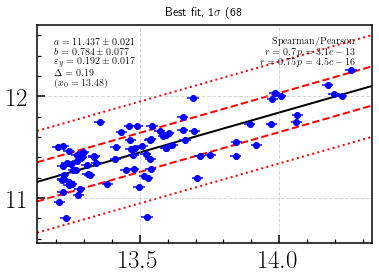

In [343]:
mask = tng_cat['cen'] & (tng_cat['logm_vir'] >= 13.2)

x_arr = tng_cat['logm_vir'][mask]
y_arr = tng_cat['logm_exs'][mask]

x_err = np.full(len(x_arr), 0.02)
y_err = np.full(len(y_arr), 0.01)

lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

sig_int:     0.0000     80.3943
Computing sig_int
sig_int:     0.0000     80.3943
sig_int:     0.2352     -0.5585
sig_int:     0.2335     -0.5524
sig_int:     0.1168      0.7693
sig_int:     0.1847     -0.2864
sig_int:     0.1464      0.1312
sig_int:     0.1585     -0.0326
sig_int:     0.1561     -0.0030
sig_int:     0.1559      0.0000
sig_int:     0.1559     -0.0010
Computing sig_int error
sig_int:     0.1559      0.1571
sig_int:     0.2352     -0.4014
sig_int:     0.1782     -0.0760
sig_int:     0.1709     -0.0098
sig_int:     0.1699      0.0001
sig_int:     0.1700     -0.0007
Repeat at best fitting solution
sig_int:     0.1559      0.0000
################# Values and formal errors ################
 intercept:  11.182 +/- 0.017
     slope:  0.543 +/- 0.063
   scatter:  0.156 +/- 0.014
Observed rms scatter: 0.16
y = a + b*(x - pivot) with pivot = 13.48
Spearman r=0.58 and p=8.3e-09
Pearson r=0.69 and p=4.2e-13
##########################################################
seconds 18.24


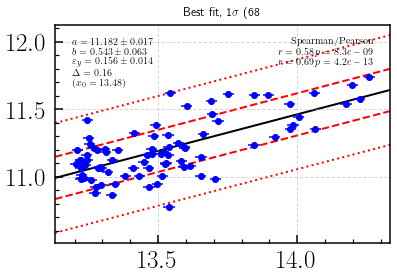

In [315]:
mask = tng_cat['cen'] & (tng_cat['logm_vir'] >= 13.2)

x_arr = tng_cat['logm_vir'][mask]
y_arr = tng_cat['logm_ins'][mask]

x_err = np.full(len(x_arr), 0.02)
y_err = np.full(len(y_arr), 0.01)

lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

sig_int:     0.0000     47.7990
Computing sig_int
sig_int:     0.0000     47.7990
sig_int:     0.2724     -0.4471
sig_int:     0.2699     -0.4368
sig_int:     0.1637      0.5054
sig_int:     0.2207     -0.1615
sig_int:     0.1988      0.0298
sig_int:     0.2022     -0.0040
sig_int:     0.2018     -0.0001
sig_int:     0.2017      0.0009
Computing sig_int error
sig_int:     0.2018      0.1570
sig_int:     0.2724     -0.2900
sig_int:     0.2266     -0.0471
sig_int:     0.2209     -0.0059
sig_int:     0.2201      0.0000
sig_int:     0.2202     -0.0008
Repeat at best fitting solution
sig_int:     0.2018     -0.0001
################# Values and formal errors ################
 intercept:  10.860 +/- 0.023
     slope:  0.921 +/- 0.081
   scatter:  0.202 +/- 0.018
Observed rms scatter: 0.20
y = a + b*(x - pivot) with pivot = 13.48
Spearman r=0.73 and p=3.3e-15
Pearson r=0.78 and p=2.8e-18
##########################################################
seconds 17.30


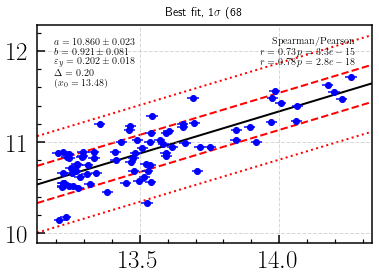

In [344]:
mask = tng_cat['cen'] & (tng_cat['logm_vir'] >= 13.2)

x_arr = tng_cat['logm_vir'][mask]
y_arr = tng_cat['logms_40_100'][mask]

x_err = np.full(len(x_arr), 0.02)
y_err = np.full(len(y_arr), 0.02)

lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

sig_int:     0.0000     34.4738
Computing sig_int
sig_int:     0.0000     34.4738
sig_int:     0.1884     -0.3991
sig_int:     0.1863     -0.3853
sig_int:     0.1266      0.3063
sig_int:     0.1530     -0.0962
sig_int:     0.1467     -0.0187
sig_int:     0.1453      0.0003
sig_int:     0.1453     -0.0007
Computing sig_int error
sig_int:     0.1453      0.1574
sig_int:     0.1884     -0.2420
sig_int:     0.1623     -0.0371
sig_int:     0.1590     -0.0046
sig_int:     0.1586      0.0000
sig_int:     0.1587     -0.0008
Repeat at best fitting solution
sig_int:     0.1453      0.0003
################# Values and formal errors ################
 intercept:  11.610 +/- 0.016
     slope:  0.660 +/- 0.059
   scatter:  0.145 +/- 0.013
Observed rms scatter: 0.15
y = a + b*(x - pivot) with pivot = 13.48
Spearman r=0.7 and p=2.6e-13
Pearson r=0.78 and p=4.5e-18
##########################################################
seconds 16.40


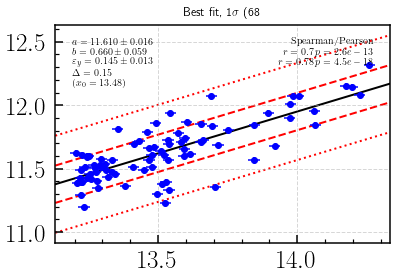

In [345]:
mask = tng_cat['cen'] & (tng_cat['logm_vir'] >= 13.2)

x_arr = tng_cat['logm_vir'][mask]
y_arr = tng_cat['logms_100'][mask]

x_err = np.full(len(x_arr), 0.02)
y_err = np.full(len(y_arr), 0.02)

lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

sig_int:     0.0000     31.0053
Computing sig_int
sig_int:     0.0000     31.0053
sig_int:     0.1660     -0.3855
sig_int:     0.1640     -0.3704
sig_int:     0.1145      0.2661
sig_int:     0.1352     -0.0818
sig_int:     0.1303     -0.0141
sig_int:     0.1293      0.0002
sig_int:     0.1294     -0.0008
Computing sig_int error
sig_int:     0.1293      0.1573
sig_int:     0.1660     -0.2284
sig_int:     0.1443     -0.0344
sig_int:     0.1416     -0.0043
sig_int:     0.1412      0.0000
sig_int:     0.1413     -0.0008
Repeat at best fitting solution
sig_int:     0.1293      0.0002
################# Values and formal errors ################
 intercept:  11.296 +/- 0.015
     slope:  0.541 +/- 0.052
   scatter:  0.129 +/- 0.012
Observed rms scatter: 0.13
y = a + b*(x - pivot) with pivot = 13.48
Spearman r=0.66 and p=1e-11
Pearson r=0.75 and p=2.5e-16
##########################################################
seconds 16.50


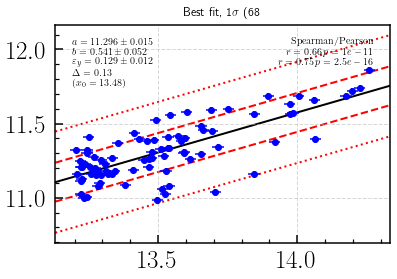

In [346]:
mask = tng_cat['cen'] & (tng_cat['logm_vir'] >= 13.2)

x_arr = tng_cat['logm_vir'][mask]
y_arr = tng_cat['logms_10'][mask]

x_err = np.full(len(x_arr), 0.02)
y_err = np.full(len(y_arr), 0.02)

lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

In [347]:
# Illustris
logm_exs_ori = 11.528 + 0.800 * (logmh_grid - 13.44)
sigm_exs_ori = 0.21

logm_ins_ori = 11.384 + 0.360 * (logmh_grid - 13.44)
sigm_ins_ori = 0.14

logm_out_ori = 10.994 + 0.920 * (logmh_grid - 13.44)
sigm_out_ori = 0.21

logm_100_ori = 11.740 + 0.594 * (logmh_grid - 13.44)
sigm_100_ori = 0.14

logm_10_ori = 11.444 + 0.389 * (logmh_grid - 13.44)
sigm_10_ori = 0.12

# TNG
logm_exs_tng = 11.437 + 0.784 * (logmh_grid - 13.48)
sigm_exs_tng = 0.19

logm_ins_tng = 11.182 + 0.543 * (logmh_grid - 13.48)
sigm_ins_tng = 0.16

logm_out_tng = 10.860 + 0.921 * (logmh_grid - 13.48)
sigm_out_tng = 0.21

logm_100_tng = 11.610 + 0.660 * (logmh_grid - 13.48)
sigm_100_tng = 0.15

logm_10_tng = 11.296 + 0.541 * (logmh_grid - 13.48)
sigm_10_tng = 0.13

### Assign CAMIRA richness to ASAP halos

- Based on the Mvir-richness relation of CAMIRA clusters from Murata et al. (2019)

- $P(\ln N \mid M, z)=\frac{1}{\sqrt{2 \pi} \sigma_{\ln N \mid M, z}} \exp \left(-\frac{x^{2}(N, M, z)}{2 \sigma_{\ln N \mid M, z}^{2}}\right)$

- $\begin{aligned} x(N, M, z) & \equiv \ln N-\left[A+B \ln \left(\frac{M}{M_{\text {pivot }}}\right)\right.\\ & \left.+B_{z} \ln \left(\frac{1+z}{1+z_{\text {pivot }}}\right)+C_{z}\left[\ln \left(\frac{1+z}{1+z_{\text {pivot }}}\right)\right]^{2}\right] \end{aligned}$

- $\begin{aligned} \sigma_{\ln N \mid M, z} &=\sigma_{0}+q \ln \left(\frac{M}{M_{\text {pivot }}}\right) \\ &+q_{z} \ln \left(\frac{1+z}{1+z_{\text {pivot }}}\right)+p_{z}\left[\ln \left(\frac{1+z}{1+z_{\text {pivot }}}\right)\right]^{2} \end{aligned}$

- Parameters for low-z ($0.1 < z < 0.4$) clusters using Planck cosmology:
    - $A = 3.34^{+0.25}_{-0.20}$
    - $B = 0.85^{+0.08}_{-0.07}$
    - $\sigma_0 = 0.36^{+0.07}_{-0.21}$
    - $q = -0.06^{0.09}_{-0.11}$
    
- Parameters for full redshift range using Planck cosmology:
    - $A = 3.15^{+0.07}_{-0.08}$
    - $B = 0.86^{+0.05}_{-0.05}$
    - $B_{z} = -0.21^{+0.35}_{-0.42}$
    - $C_{z} = 3.61^{+1.96}_{-2.23}$
    - $\sigma_0 = 0.32^{+0.06}_{-0.06}$
    - $q = -0.06^{+0.09}_{-0.11}$
    - $q_{z} = 0.03^{+0.31}_{-0.30}$
    - $p_{z} = 0.70^{+1.71}_{-1.60}$
    
- Pivot redshift and mass
    - $M_{\rm Pivot} = 3\times 10^{14} h^{-1} M_{\odot}$
    - $z_{\rm Pivot} = 0.6$
  
- Here, $M \equiv M_{200m}$ and $h=0.68$.

In [260]:
def mean_ln_N(m200m, z=None, m_pivot=3e14, h=0.68, A=3.15, B=0.86, 
              z_pivot=0.6, B_z=-0.21, C_z=3.61):
    """
    Estimate the mean ln(N) for CAMIRA clusters based on the halo mass-richness
    relation calibrated by Murata et al. (2019).
    """
    lnN = A + B * np.log(m200m / m_pivot / h)
    
    if z is None:
        return lnN
    
    z_term = np.log((1 + z) / (1 + z_pivot))
    
    return lnN + B_z * z_term + C_z * (z_term ** 2)

In [261]:
def sig_ln_N(m200m, z=None, m_pivot=3e14, h=0.68, sig0=0.32, z_pivot=0.6,
             q=-0.06, q_z=0.03, p_z=0.70):
    """
    Estimate the scatter of ln(N) for CAMINRA clusters based on the halo mass-richness
    relation calibrated by Murata et al. (2019).
    """
    sig_lnN = sig0 + q * np.log(m200m / m_pivot / h)
    
    if z is None:
        return sig_lnN
    
    z_term = np.log((1 + z) / (1 + z_pivot))
    
    return sig_lnN + q_z * z_term + p_z * (z_term ** 2)

[0.84655597] -10.824666473043003


(0.1, 2.6)

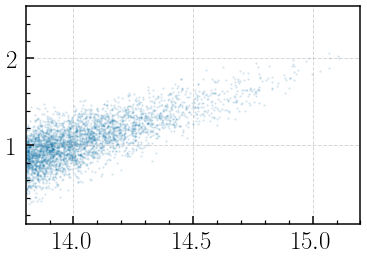

In [262]:
lnN = np.random.normal(
    loc=mean_ln_N(um_cen['m200b_hlist'], z=0.4), 
    scale=sig_ln_N(um_cen['m200b_hlist'], z=0.4))

log10_N = np.log10(np.exp(lnN))

x_arr = np.log10(um_cen['mvir'])
y_arr = log10_N
mask = x_arr >= 14.0

x_err = np.full(len(x_arr), 0.02)
y_err = np.full(len(y_arr), 0.01)

reg = LinearRegression().fit(
    x_arr[mask].reshape(-1, 1), y_arr[mask]) 

print(reg.coef_, reg.intercept_)

plt.scatter(np.log10(um_cen['mvir']), log10_N, s=2, alpha=0.1)
plt.xlim(13.8, 15.2)
plt.ylim(0.1, 2.6)

sig_int:     0.0000     41.0496
Computing sig_int
sig_int:     0.0000     41.0496
sig_int:     0.2025     -0.4114
sig_int:     0.2005     -0.3997
sig_int:     0.1327      0.3523
sig_int:     0.1645     -0.1123
sig_int:     0.1568     -0.0248
sig_int:     0.1548      0.0005
sig_int:     0.1549     -0.0005
Computing sig_int error
sig_int:     0.1549      0.0331
sig_int:     0.2025     -0.3778
sig_int:     0.1587     -0.0139
sig_int:     0.1576     -0.0004
sig_int:     0.1575      0.0006
Repeat at best fitting solution
sig_int:     0.1549     -0.0005
################# Values and formal errors ################
 intercept:  1.1615 +/- 0.0039
     slope:  0.864 +/- 0.018
   scatter:  0.1549 +/- 0.0027
Observed rms scatter: 0.16
y = a + b*(x - pivot) with pivot = 14.17
Spearman r=0.67 and p=2.4e-233
Pearson r=0.75 and p=3e-323
##########################################################
seconds 8.62


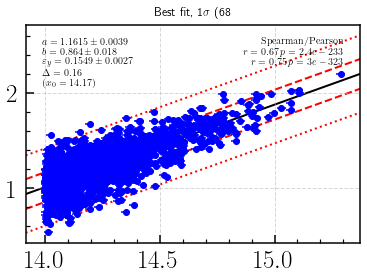

In [210]:
lts_linefit.lts_linefit(
    x_arr[mask], y_arr[mask], x_err[mask], y_err[mask], pivot=np.nanmedian(x_arr[mask]), clip=4.0)

In [339]:
logmh_grid = np.linspace(13.6, 15.3, 30)

# Relation for M*ex-situ 
logm_exs = 11.7441 + 0.867 * (logmh_grid - 14.17)
sigm_exs = 0.25

# Relation for M*in-situ 
logm_ins = 11.0242 + 0.141 * (logmh_grid - 14.17)
sigm_ins = 0.37

# Relation for M*[50-100]
logm_out = 11.0284 + 0.521 * (logmh_grid - 14.17)
sigm_out = 0.3

# Relation for richness
nmem_cam = 1.1615 + 0.864 * (logmh_grid - 14.17)
sign_cam = 0.16

(13.75, 15.25)

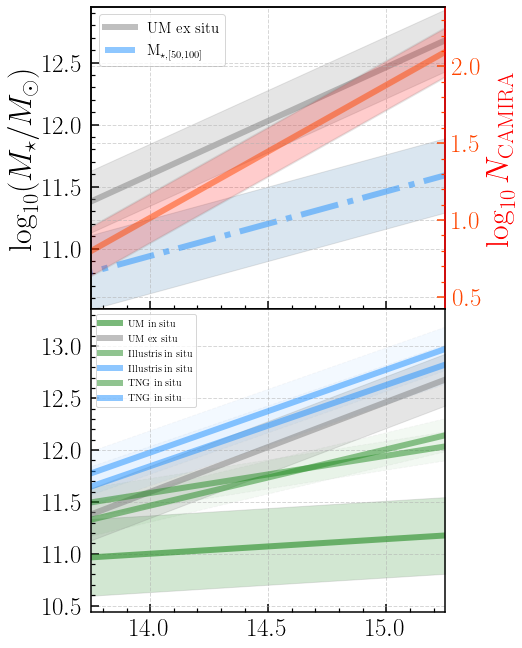

In [362]:
fig = plt.figure(figsize=(6, 10))
fig.subplots_adjust(
    left=0.175, bottom=0.09, right=0.995, top=0.93, wspace=0, hspace=0)

ax1 = fig.add_subplot(2, 1, 1)

ax1.fill_between(
    logmh_grid, logm_exs - sigm_exs, logm_exs + sigm_exs,
    alpha=0.2, edgecolor='grey', linewidth=1.0,
    label=r'__no_label__', facecolor='grey', linestyle='-', rasterized=True)

l2 = ax1.plot(logmh_grid, logm_exs, linestyle='-', linewidth=6, alpha=0.5, 
              label=r'$\rm UM\ ex\ situ$', color='grey')

ax1.fill_between(
    logmh_grid, logm_out - sigm_out, logm_out + sigm_out,
    alpha=0.2, edgecolor='grey', linewidth=1.0,
    label=r'__no_label__', facecolor='steelblue', linestyle='-', rasterized=True)

l3 = ax1.plot(logmh_grid, logm_out, linestyle='-.', linewidth=6, alpha=0.5, 
              label=r'$\rm M_{\star,[50,100]}$', color='dodgerblue')

ax1.set_xlabel(r'$\log_{10} (M_{\rm vir}/ M_{\odot})$', fontsize=32)
ax1.set_ylabel(r'$\log_{10} (M_{\star}/M_{\odot})$', fontsize=32)

ax1.legend(loc='best', fontsize=15)

#------------------------------------------------------------------------------------#

ax2=ax1.twinx()
ax2.yaxis.label.set_color('orangered')
ax2.tick_params(axis='y', colors='orangered', which='both')
ax2.spines['right'].set_color('red')

ax2.set_ylabel(r"$\log_{10} N_{\rm CAMIRA}$", color="red", fontsize=32)
ax2.fill_between(
    logmh_grid, nmem_cam - sign_cam, nmem_cam + sign_cam,
    alpha=0.2, edgecolor='grey', linewidth=2.0,
    label=r'__no_label__', facecolor='red', linestyle='-', rasterized=True)

l4 = ax2.plot(logmh_grid, nmem_cam, linestyle='-', linewidth=6, alpha=0.5, 
              label=r'$\rm N_{\rm CAMIRA}$', color='orangered')

ax1.set_ylim(10.51, 12.95)
ax1.set_xticklabels([])

#------------------------------------------------------------------------------------#

ax3 = fig.add_subplot(2, 1, 2)

# Universe Machine
ax3.fill_between(
    logmh_grid, logm_ins - sigm_ins, logm_ins + sigm_ins,
    alpha=0.2, edgecolor='grey', linewidth=1.0,
    label=r'__no_label__', facecolor='forestgreen', linestyle='-', rasterized=True)

l1 = ax3.plot(logmh_grid, logm_ins, linestyle='-', linewidth=6, alpha=0.6, 
              label=r'$\rm UM\ in\ situ$', color='forestgreen')

ax3.fill_between(
    logmh_grid, logm_exs - sigm_exs, logm_exs + sigm_exs,
    alpha=0.2, edgecolor='grey', linewidth=1.0,
    label=r'__no_label__', facecolor='grey', linestyle='-', rasterized=True)

l2 = ax3.plot(logmh_grid, logm_exs, linestyle='-', linewidth=6, alpha=0.5, 
              label=r'$\rm UM\ ex\ situ$', color='grey')

# Illustris
ax3.fill_between(
    logmh_grid, logm_ins_ori - sigm_ins_ori, logm_ins_ori + sigm_ins_ori,
    alpha=0.05, edgecolor='grey', linewidth=1.0,
    label=r'__no_label__', facecolor='forestgreen', linestyle='--', rasterized=True)

l3 = ax3.plot(logmh_grid, logm_ins_ori, linestyle='-', linewidth=6, alpha=0.5, 
              label=r'$\rm Illustris\ in\ situ$', color='forestgreen')

ax3.fill_between(
    logmh_grid, logm_exs_ori - sigm_exs_ori, logm_exs_ori + sigm_exs_ori,
    alpha=0.05, edgecolor='grey', linewidth=1.0,
    label=r'__no_label__', facecolor='dodgerblue', linestyle='--', rasterized=True)

l4 = ax3.plot(logmh_grid, logm_exs_ori, linestyle='-', linewidth=6, alpha=0.5, 
              label=r'$\rm Illustris\ in\ situ$', color='dodgerblue')

# TNG
ax3.fill_between(
    logmh_grid, logm_ins_tng - sigm_ins_tng, logm_ins_tng + sigm_ins_tng,
    alpha=0.05, edgecolor='grey', linewidth=1.0,
    label=r'__no_label__', facecolor='forestgreen', linestyle='--', rasterized=True)

l3 = ax3.plot(logmh_grid, logm_ins_tng, linestyle='-', linewidth=6, alpha=0.5, 
              label=r'$\rm TNG\ in\ situ$', color='forestgreen')

ax3.fill_between(
    logmh_grid, logm_exs_tng - sigm_exs_tng, logm_exs_tng + sigm_exs_tng,
    alpha=0.05, edgecolor='grey', linewidth=1.0,
    label=r'__no_label__', facecolor='dodgerblue', linestyle='--', rasterized=True)

l4 = ax3.plot(logmh_grid, logm_exs_tng, linestyle='-', linewidth=6, alpha=0.5, 
              label=r'$\rm TNG\ in\ situ$', color='dodgerblue')

ax3.legend(loc='best')

ax1.set_xlim(13.75, 15.25)
ax2.set_xlim(13.75, 15.25)
ax3.set_xlim(13.75, 15.25)

In [177]:
cat_cam = Table()

cat_cam['logmh'] = np.log10(halo_cat['Mvir'])
cat_cam['logn'] = log10_N
cat_cam.sort('logn')
cat_cam.reverse()

print(np.round(np.nanstd(cat_cam[rank_mdpl2[0]:rank_mdpl2[1]]['logmh']), 2))
print(np.round(np.nanstd(cat_cam[rank_mdpl2[1]:rank_mdpl2[2]]['logmh']), 2))
print(np.round(np.nanstd(cat_cam[rank_mdpl2[2]:rank_mdpl2[3]]['logmh']), 2))
print(np.round(np.nanstd(cat_cam[rank_mdpl2[3]:rank_mdpl2[4]]['logmh']), 2))

0.21
0.2
0.22
0.23


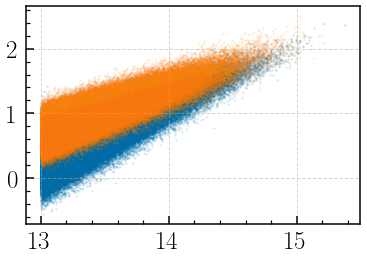

In [102]:
plt.scatter(np.log10(halo_cat['Mvir']), logms - 11.5, s=2, alpha=0.1)

In [6]:
# Pre-compute
hsc_pre = Table.read(os.path.join(data_dir, 's16a_massive_logm_11.2.fits'))

mask = (
    (hsc_pre['logm_10_100'] >= 9.5) & (hsc_pre['logm_max'] >= 11.2) & 
    (hsc_pre['logm_50_100'] >= 9.5) & (hsc_pre['bsm_s18a'])
)

data_use = hsc_pre[mask]

In [ ]:
np.linspace(13.5)

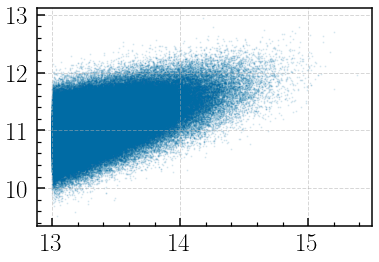

In [190]:
alpha, pi = 0.6, 3.09
sigms = 0.30

logms = np.random.normal(loc=(alpha * np.log10(halo_cat['Mvir']) + pi), scale=sigms)

plt.scatter(np.log10(halo_cat['Mvir']), logms, alpha=0.1, s=1)

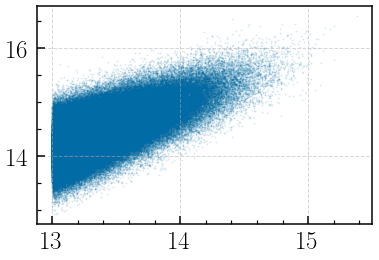

In [189]:
alpha, pi = 0.85, 3.09
sigms = 0.30

logms = np.random.normal(loc=(alpha * np.log10(halo_cat['Mvir']) + pi), scale=sigms)

plt.scatter(np.log10(halo_cat['Mvir']), logms, alpha=0.1, s=1)

In [98]:
cat_m100 = Table()
cat_m100['logmh'] = np.log10(halo_cat['M200b'])
cat_m100['logms'] = logms
cat_m100.sort('logms')
cat_m100.reverse()

In [99]:
np.nanstd(cat_m100[rank_mdpl2[1]:rank_mdpl2[2]]['logmh'])

0.2102594269076395

In [120]:
mvir = 10.0 ** (data_use['logmh_vir_plane'])
z = data_use['z_best']

In [121]:
lnN = np.random.normal(loc=mean_ln_N(mvir, z=z), scale=sig_ln_N(mvir, z=z))

log10_N = np.log10(np.exp(lnN))

In [128]:
np.std(np.sort(lnN)[50:200])

0.08352336441359061

(9.5, 12.5)

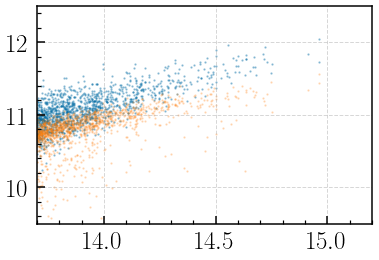

In [132]:
plt.scatter(data_use['logmh_vir_plane'], log10_N +10, s=2, alpha=0.3)

plt.scatter(data_use['logmh_vir_plane'], data_use['logm_50_100'], s=2, alpha=0.2)

plt.xlim(13.7, 15.2)

plt.ylim(9.5, 12.5)

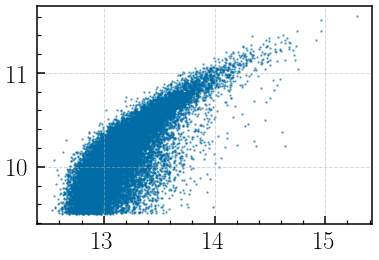

In [109]:
sigo_to_sigm(0.35, alpha=0.6, beta2=2.959)

0.41177111759327206

In [116]:
sigo_to_sigm(0.30, alpha=0.8, beta2=2.959)

0.3151250073116114

In [7]:
1 / 1.3

0.7692307692307692